<a href="https://colab.research.google.com/github/harinivasudatla/Harini_Datla/blob/main/Stability_AI_1_Text_to_Image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

🧨 Diffusers provides state-of-the-art pretrained diffusion models across multiple modalities. Its purpose is to serve as a modular toolbox for both inference and training.</br>
Documentation Link: https://huggingface.co/docs/diffusers/using-diffusers/write_own_pipeline


In [ ]:
!pip install diffusers["torch"] transformers

In [ ]:
!pip install diffusers["flax"] transformers

# A simple pipeline:
A pipeline is a quick and easy way to run a model for inference, requiring no more than four lines of code to generate an image:

diffusion_pytorch_model.safetensors not found


  0%|          | 0/15 [00:00<?, ?it/s]

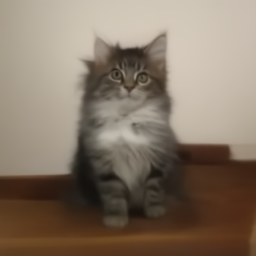

In [ ]:
from diffusers import DDPMPipeline

ddpm = DDPMPipeline.from_pretrained("google/ddpm-cat-256").to("cuda")
image = ddpm(num_inference_steps=15).images[0]
image

# Steps to create Diffusion pipelines


1. Load the model and scheduler:

In [ ]:
from diffusers import DDPMScheduler, UNet2DModel

scheduler = DDPMScheduler.from_pretrained("google/ddpm-cat-256")
model = UNet2DModel.from_pretrained("google/ddpm-cat-256").to("cuda")

2. Set the number of timesteps to run the denoising process for:

In [ ]:
scheduler.set_timesteps(50)

In [ ]:
scheduler.timesteps #Setting the scheduler timesteps creates a tensor with evenly spaced elements in it, 50 in this example.

tensor([980, 960, 940, 920, 900, 880, 860, 840, 820, 800, 780, 760, 740, 720,
        700, 680, 660, 640, 620, 600, 580, 560, 540, 520, 500, 480, 460, 440,
        420, 400, 380, 360, 340, 320, 300, 280, 260, 240, 220, 200, 180, 160,
        140, 120, 100,  80,  60,  40,  20,   0])

3.Create some random noise with the same shape as the desired output:

In [ ]:
import torch

sample_size = model.config.sample_size
noise = torch.randn((1, 3, sample_size, sample_size)).to("cuda")

4. Write a loop to iterate over the timesteps. At each timestep, the model does a UNet2DModel.forward() pass and returns the noisy residual. The scheduler’s step() method takes the noisy residual, timestep, and input and it predicts the image at the previous timestep. This output becomes the next input to the model in the denoising loop, and it’ll repeat until it reaches the end of the timesteps array.

In [ ]:

input = noise

for t in scheduler.timesteps:
    with torch.no_grad():
        noisy_residual = model(input, t).sample
    previous_noisy_sample = scheduler.step(noisy_residual, t, input).prev_sample
    input = previous_noisy_sample

5. The last step is to convert the denoised output into an image:

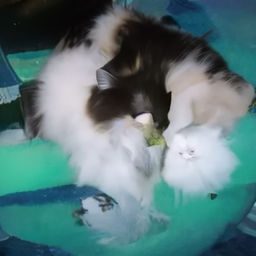

In [ ]:
from PIL import Image
import numpy as np

image = (input / 2 + 0.5).clamp(0, 1)
image = image.cpu().permute(0, 2, 3, 1).numpy()[0]
image = Image.fromarray((image * 255).round().astype("uint8"))
image

# Deconstruct the Pipeline

Stable Diffusion is a text-to-image latent diffusion model. It is called a latent diffusion model because it works with a lower-dimensional representation of the image instead of the actual pixel space, which makes it more memory efficient. The encoder compresses the image into a smaller representation, and a decoder to convert the compressed representation back into an image. For text-to-image models, you’ll need a tokenizer and an encoder to generate text embeddings. From the previous example, you already know you need a UNet model and a scheduler.

As you can see, this is already more complex than the DDPM pipeline which only contains a UNet model. The Stable Diffusion model has three separate pretrained models.(Source:https://huggingface.co/docs/diffusers/using-diffusers/write_own_pipeline)



In [ ]:
#load all these components with the from_pretrained() method
from PIL import Image
import torch
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler

vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")
tokenizer = CLIPTokenizer.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="text_encoder")
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

In [ ]:
from diffusers import UniPCMultistepScheduler

scheduler = UniPCMultistepScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")

In [ ]:
from diffusers import UniPCMultistepScheduler

scheduler = UniPCMultistepScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")

In [ ]:
#To speed up inference, move the models to a GPU since, unlike the scheduler, they have trainable weights:

torch_device = "cuda"
vae.to(torch_device)
text_encoder.to(torch_device)
unet.to(torch_device)

UNet2DConditionModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (down_blocks): ModuleList(
    (0): CrossAttnDownBlock2D(
      (attentions): ModuleList(
        (0-1): 2 x Transformer2DModel(
          (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
          (proj_in): Conv2d(320, 320, kernel_size=(1, 1), stride=(1, 1))
          (transformer_blocks): ModuleList(
            (0): BasicTransformerBlock(
              (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
              (attn1): Attention(
                (to_q): Linear(in_features=320, out_features=320, bias=False)
                (to_k): Linear(in_features=320, out_features=320, bias=False)
                (to_v): Linear(in_features=320, out_fe

In [ ]:
#Tokenize the text to generate embeddings. The text is used to condition the UNet model and steer the diffusion process towards something that resembles the input prompt.
prompt = ["a photograph of a dog with a hat"]
height = 512  # default height of Stable Diffusion
width = 512  # default width of Stable Diffusion
num_inference_steps = 25  # Number of denoising steps
guidance_scale = 7.5  # Scale for classifier-free guidance
generator = torch.manual_seed(0)  # Seed generator to create the inital latent noise
batch_size = len(prompt)

In [ ]:
#Tokenize the text and generate the embeddings from the prompt:

text_input = tokenizer(
    prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")


with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

In [ ]:
"""
Generate the unconditional text embeddings which are the embeddings for the padding token.
These need to have the same shape (batch_size and seq_length) as the conditional text_embeddings:
"""
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer([""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt")
uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]


In [ ]:
#concatenate the conditional and unconditional embeddings into a batch to avoid doing two forward passes:
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

In [ ]:
"""generate some initial random noise as a starting point for the diffusion process.
 This is the latent representation of the image, and it’ll be gradually denoised.
 At this point, the latent image is smaller than the final image size but that’s
 okay though because the model will transform it into the final 512x512 image dimensions later."""

2 ** (len(vae.config.block_out_channels) - 1) == 8 # The height and width are divided by 8 because the vae model has 3 down-sampling layers.

True

In [ ]:
latents = torch.randn(
    (batch_size, unet.in_channels, height // 8, width // 8),
    generator=generator,
)
latents = latents.to(torch_device)

<ipython-input-31-007cfaacb096>:2: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


In [ ]:
#Denoise the image
latents = latents * scheduler.init_noise_sigma


"""
The last step is to create the denoising loop that’ll progressively transform the pure noise in latents to an image described by your prompt. Remember, the denoising loop needs to do three things:</br>

Set the scheduler’s timesteps to use during denoising.</br>
Iterate over the timesteps.</br>
At each timestep, call the UNet model to predict the noise residual and pass it to the scheduler to compute the previous noisy sample.</br>
"""

In [ ]:
from tqdm.auto import tqdm

scheduler.set_timesteps(num_inference_steps)

for t in tqdm(scheduler.timesteps):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)

    latent_model_input = scheduler.scale_model_input(latent_model_input, timestep=t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    # perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # compute the previous noisy sample x_t -> x_t-1
    latents = scheduler.step(noise_pred, t, latents).prev_sample

  0%|          | 0/25 [00:00<?, ?it/s]

In [ ]:
#Decode the image
# scale and decode the image latents with vae
latents = 1 / 0.18215 * latents
with torch.no_grad():
    image = vae.decode(latents).sample

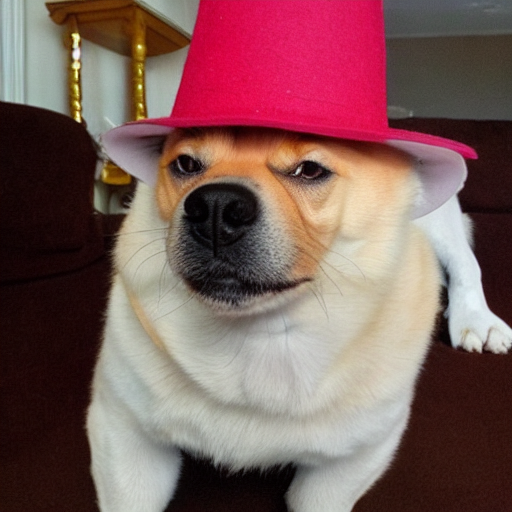

In [ ]:
image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]